In [458]:

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to hide/display code"></form>''')



# COVID-19 Future Cases Predictor

In [459]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import optimize
import numpy as np
import datetime
from IPython.display import Markdown, display
import ipywidgets as widgets
from ipywidgets import HBox, Label
from IPython.display import Javascript
df_nov = pd.read_csv("covid_19_data.csv")
df_nov = df_nov.rename(columns={'Country/Region':'Country'})
df_nov = df_nov.rename(columns={'ObservationDate':'Date'})


        
df = pd.read_csv("https://open-covid-19.github.io/data/data.csv")
df['Confirmed'] = df['Confirmed'].astype(float)
df['Deaths'] = df['Deaths'].astype(float)
df = df.set_index('Date')

df_countrydate = df_nov[df_nov['Confirmed']>0]
df_countrydate = df_countrydate.groupby(['Date','Country']).sum().reset_index()

country_zip = tuple(zip( df['CountryName'], df['CountryCode']))

def code_on_change(v):
    global code
    code = v['new']
    
def days_on_change(v):
    global days
    days = v['new']
             
def get_outbreak_mask(data: pd.DataFrame, threshold: int = 10):
    ''' Returns a mask for > N confirmed cases '''
    return data['Confirmed'] > threshold


days = 3
code = 'US'

days_w = widgets.IntSlider(
    value=3,
    min=1,
    max=30,
    step=1,
    description='',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


code_w = widgets.Select(
    options=country_zip,
    value='US',
    # rows=10,
    description='Country:',
    disabled=False
)

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
    
display(HBox([Label('Select a country:'), code_w]), HBox([Label('Future days to predict:'), days_w]))

days_w.observe(days_on_change, names='value')
code_w.observe(code_on_change, names='value')

days_w.observe(run_all, names='value')
code_w.observe(run_all, names='value')

There are currently 1329799 cases of COVID-19 in US. In 3 days, there will be an estimated value of 1427244 cases of COVID-19 in US.

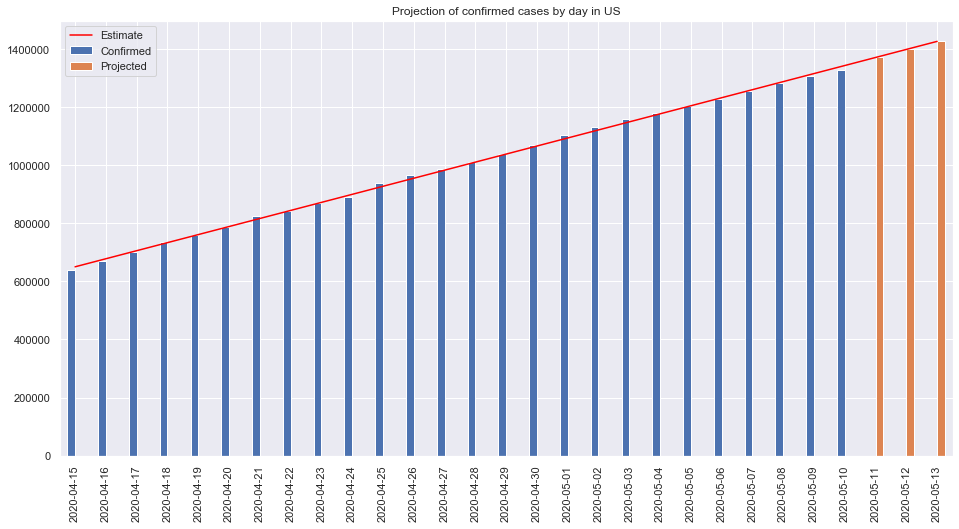

In [466]:
#Estimation

def exponential_function(x: float, a: float, b: float, c: float):
    return a * (b ** x) + c

cols = ['CountryCode', 'CountryName', 'Confirmed', 'Deaths']
one_country = df[df['CountryCode'] == code]
one_country = one_country[one_country['Key'] == code]
one_country = one_country[(one_country.index <= '2020-05-10')]
one_country = one_country[(one_country.index >= '2020-04-15')]
one_country = one_country[cols]

current_confirmed = one_country['Confirmed'][len(one_country) - 1]

X, y = list(range(len(one_country))), one_country['Confirmed'].tolist()
params, _ = optimize.curve_fit(exponential_function, X, y, maxfev=5000)


# Append N new days
date_format = '%Y-%m-%d'
date_range = [datetime.datetime.strptime(date, date_format) for date in one_country.index]
for _ in range(days): date_range.append(date_range[-1] + datetime.timedelta(days=1))
date_range = [datetime.datetime.strftime(date, date_format) for date in date_range]

# Perform projection
projected = [0] * len(X) + [exponential_function(x, *params) for x in range(len(X), len(X) + days)]
projected = pd.Series(projected, index=date_range, name='Projected')
df_ = pd.DataFrame({'Confirmed': one_country['Confirmed'], 'Projected': projected})
p1 = df_.plot(kind='bar', figsize=(16, 8))
estimate = [exponential_function(x, *params) for x in range(len(date_range))]

final_estimate = estimate[len(estimate) - 1]

display(Markdown("There are currently {} cases of COVID-19 in {}. In {} days, there will be an estimated value of {} cases of COVID-19 in {}.".format(int(current_confirmed), code, days, int(round(final_estimate)), code)))
p1.plot(date_range, estimate, color='red', label='Estimate')
plt.title("Projection of confirmed cases by day in " + code);
p1.legend();

In [461]:
display(Markdown("To see how accurate this prediction is, let's make predictions for the previous {} days, without looking at the recorded data for those days, and compare the predicitions with the real values.".format(days)))

To see how accurate this prediction is, let's make predictions for the previous 3 days, without looking at the recorded data for those days, and compare the predicitions with the real values.

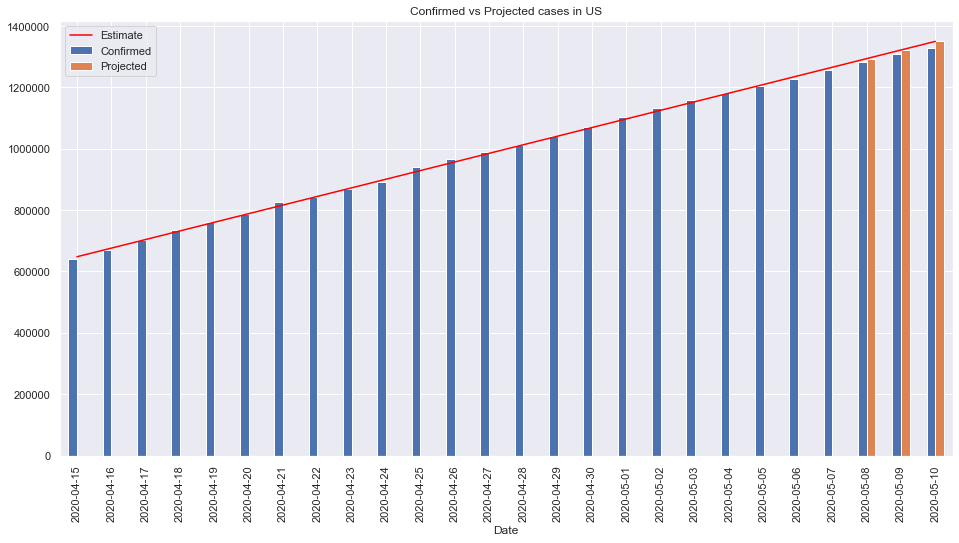

In [467]:
# Validation

params_validate, _ = optimize.curve_fit(exponential_function, X[:-days], y[:-days], maxfev=5000)

# Project zero for all values except for the last days
projected = [0] * len(X[:-days]) + [exponential_function(x, *params_validate) for x in X[-days:]]


projected = pd.Series(projected, index=one_country.index, name='Projected')
df_ = pd.DataFrame({'Confirmed': one_country['Confirmed'], 'Projected': projected})
p2 = df_.plot(kind='bar', figsize=(16, 8))
estimate = [exponential_function(x, *params_validate) for x in X]
p2.plot(one_country.index, estimate, color='red', label='Estimate')
plt.title("Confirmed vs Projected cases in " + code);
p2.legend();

It is likely that a prediction larger than a few days will be an overestimate. This is because COVID-19 is not truly growing at an exponential rate, as it is modeled here.